In [ ]:
%pip -q install datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 74.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from google.colab import userdata

hf_token = userdata.get('Polyjuiceai')

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset('keivalya/MedQuad-MedicalQnADataset')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16407 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['qtype', 'Question', 'Answer'],
        num_rows: 16407
    })
})

In [ ]:
dataset['train'].to_pandas()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."
...,...,...,...
16402,symptoms,What are the symptoms of Familial visceral myo...,What are the signs and symptoms of Familial vi...
16403,information,What is (are) Pseudopelade of Brocq ?,Pseudopelade of Brocq (PBB) is a slowly progre...
16404,symptoms,What are the symptoms of Pseudopelade of Brocq ?,What are the signs and symptoms of Pseudopelad...
16405,treatment,What are the treatments for Pseudopelade of Br...,Is there treatment or a cure for pseudopelade ...


In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-Instruct-v0.2')

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["Question"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["Answer"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
# instruction_token_counts
# output_token_counts
# combined_token_counts

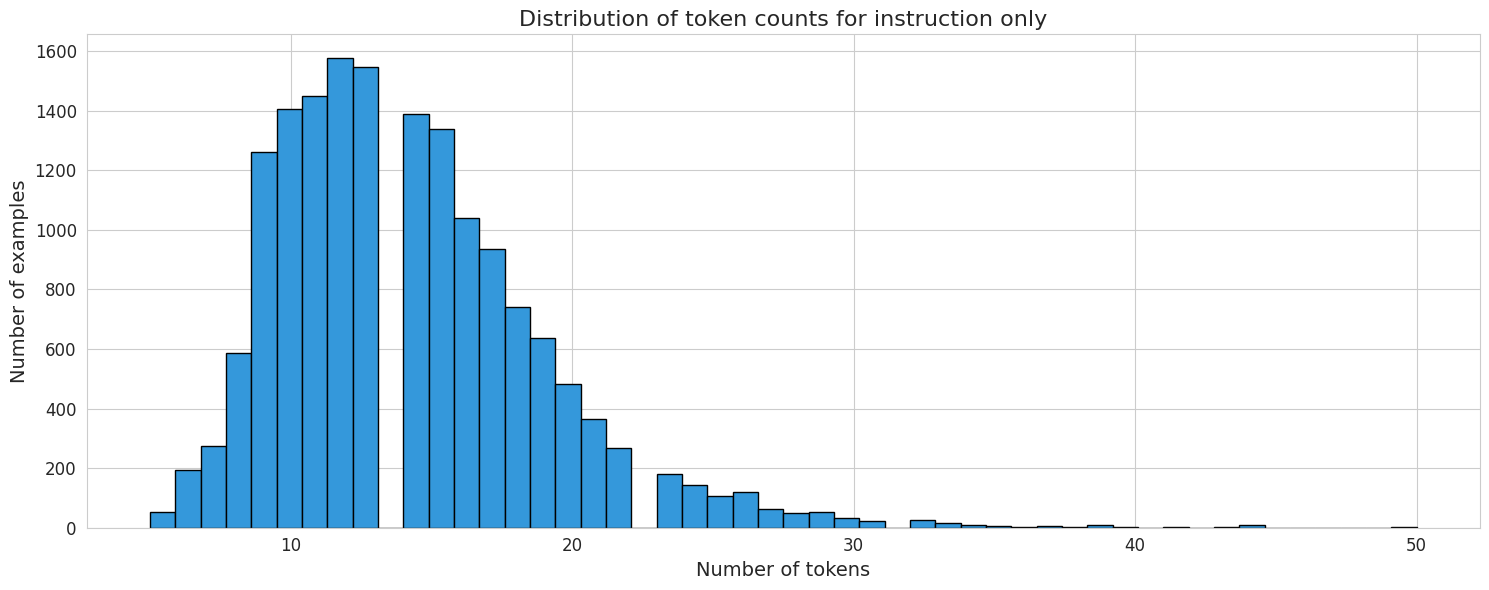

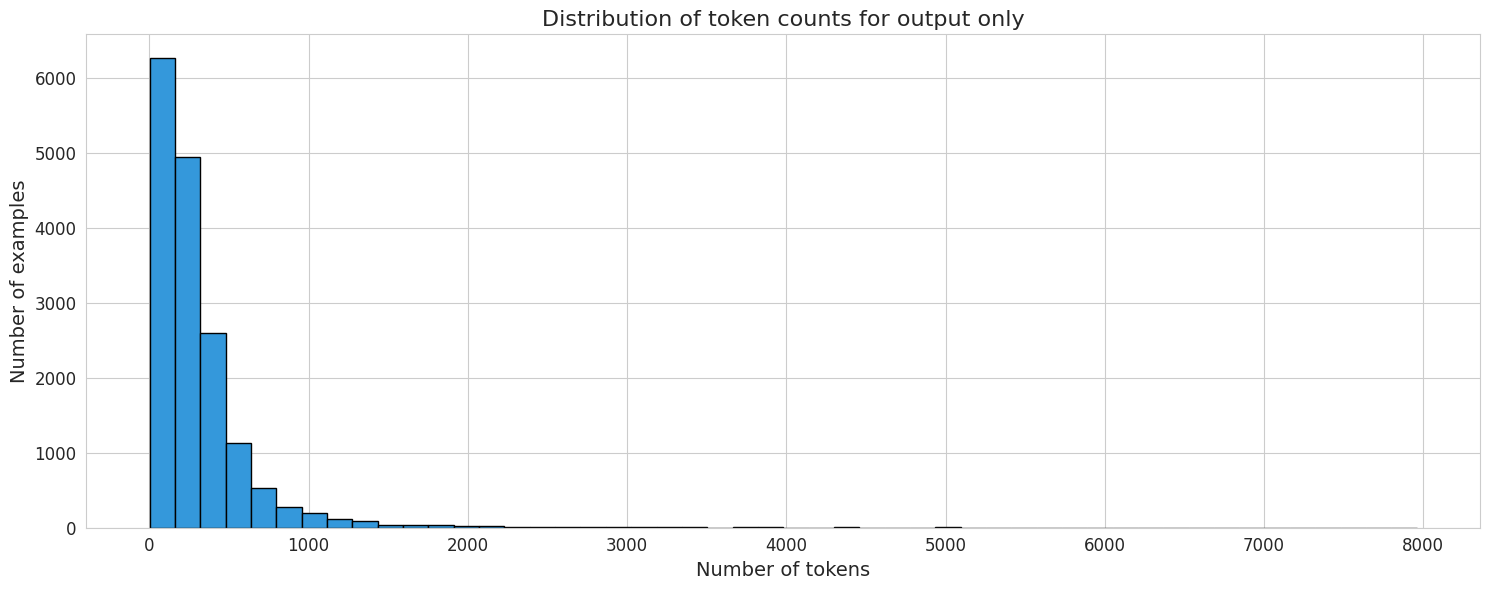

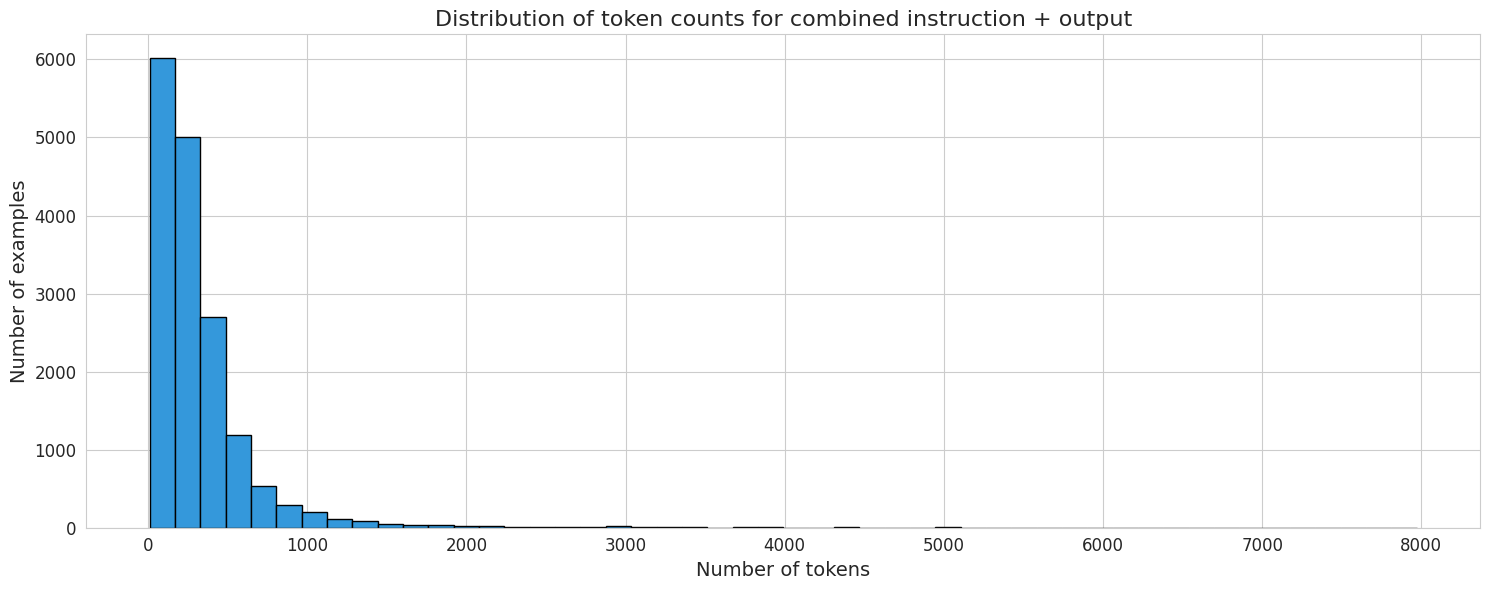

In [ ]:
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# Token limits to evaluate
token_limits = [512, 1024, 2048, 4096]

# Function to count valid indices for a given token limit
def count_valid_indices(limit):
    valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= limit]
    return len(valid_indices), len(dataset['train']) - len(valid_indices)

# Evaluate each token limit
for limit in token_limits:
    valid_count, excluded_count = count_valid_indices(limit)
    print(f"Token Limit: {limit}")
    print(f"Valid examples: {valid_count}")
    print(f"Excluded examples: {excluded_count}")
    print()

Token Limit: 512
Valid examples: 13994
Excluded examples: 2413

Token Limit: 1024
Valid examples: 15816
Excluded examples: 591

Token Limit: 2048
Valid examples: 16260
Excluded examples: 147

Token Limit: 4096
Valid examples: 16386
Excluded examples: 21



In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(len(valid_indices))
print(len(dataset['train']) - len(valid_indices))

16260
147


In [ ]:
dataset['train'] = dataset['train'].select(valid_indices)

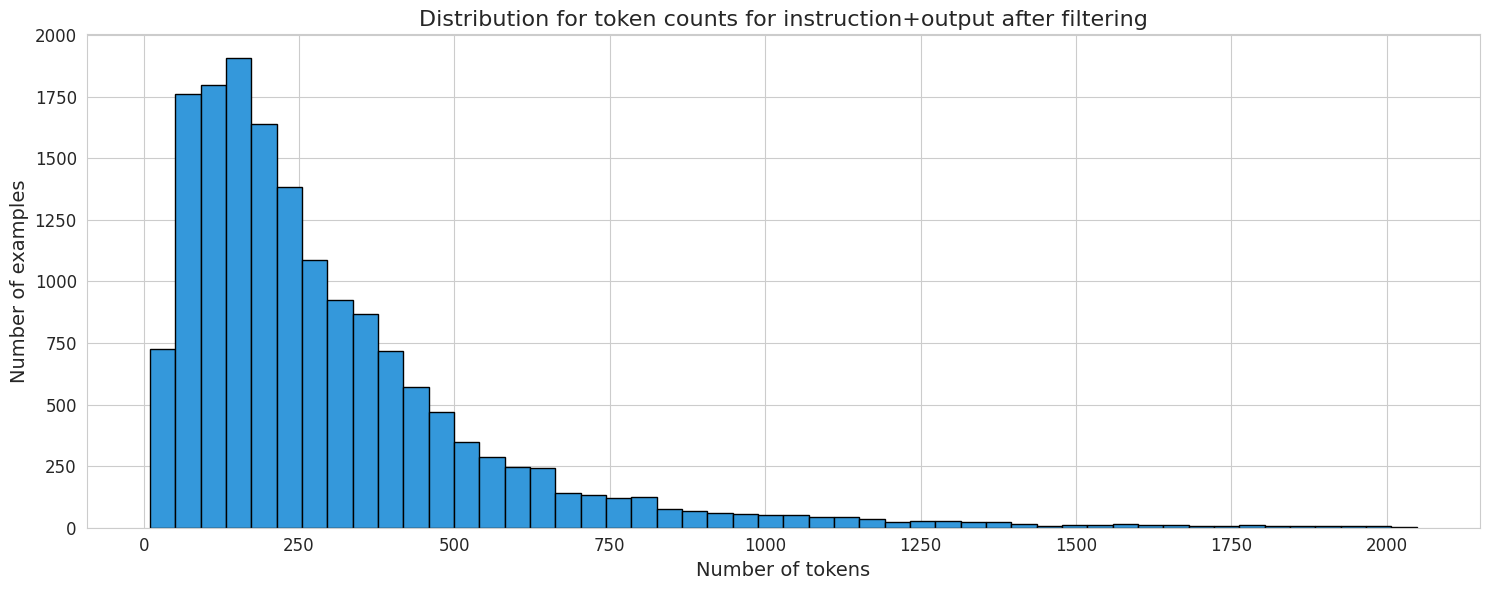

In [ ]:
token_counts = [combined_token_counts[i] for i in valid_indices]
plot_distribution(token_counts, "Distribution for token counts for instruction+output after filtering")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

# the dataset, the embedding model and the threshold for the percentage of similarity between embeddings
def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["Answer"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95) # we can use any other embeddig model

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/509 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/16260 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}") # original dataset
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}") # deduped dataset
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}") # the number of the samples that are removed

Number of samples in the original dataset: 16260
Number of samples in the deduped dataset: 13558
Number of samples that were removed: 2702


In [ ]:
# choosing the samples with the most tokens, as the dataset is still large and need to be pruned
# k: to know how many we want to have
def get_top_k_rows(dataset, token_counts, k):
    sorted_indices = sorted(range(len(token_counts)), key= lambda i: token_counts[i], reverse=True) # sorting by descending order
    top_k_indices = sorted_indices[:k] # keep just those top k
    top_k_data = {
        "instruction": [dataset['train'][i]["Question"] for i in top_k_indices], # for loop to select all the samples in the sortde_indices to keep 1000 of them
        "output": [dataset['train'][i]["Answer"] for i in top_k_indices],
    }
    return Dataset.from_dict(top_k_data)

instruction_token_counts = [len(tokenizer.tokenize(example["Question"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["Answer"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 2000
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)

dataset = DatasetDict({"train": top_k_dataset}) # save it as a dictionary to make sure we still have it as train split - nor much important

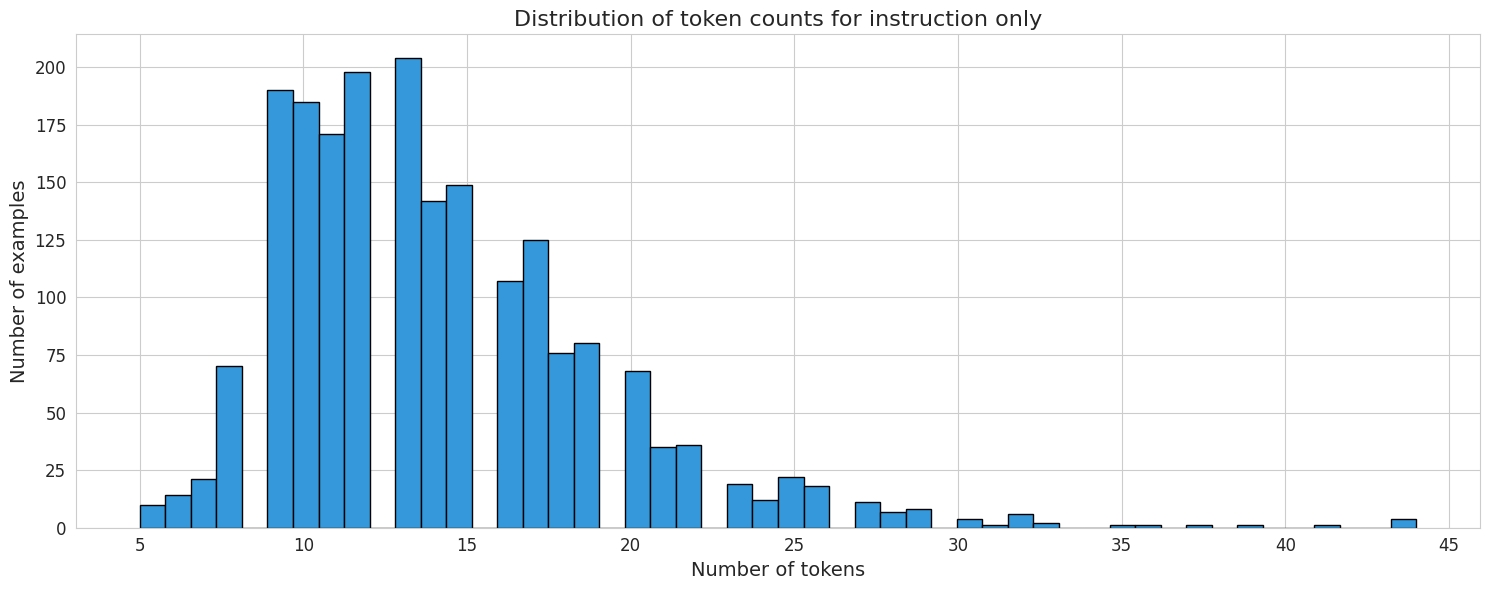

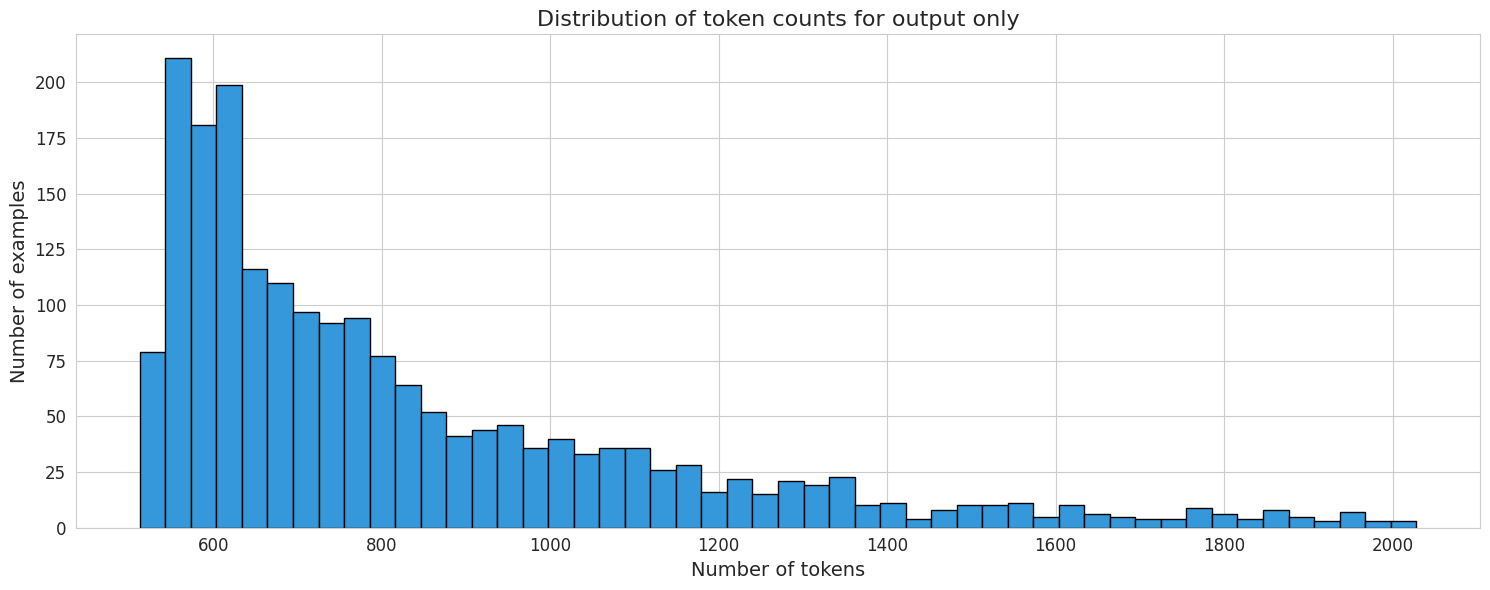

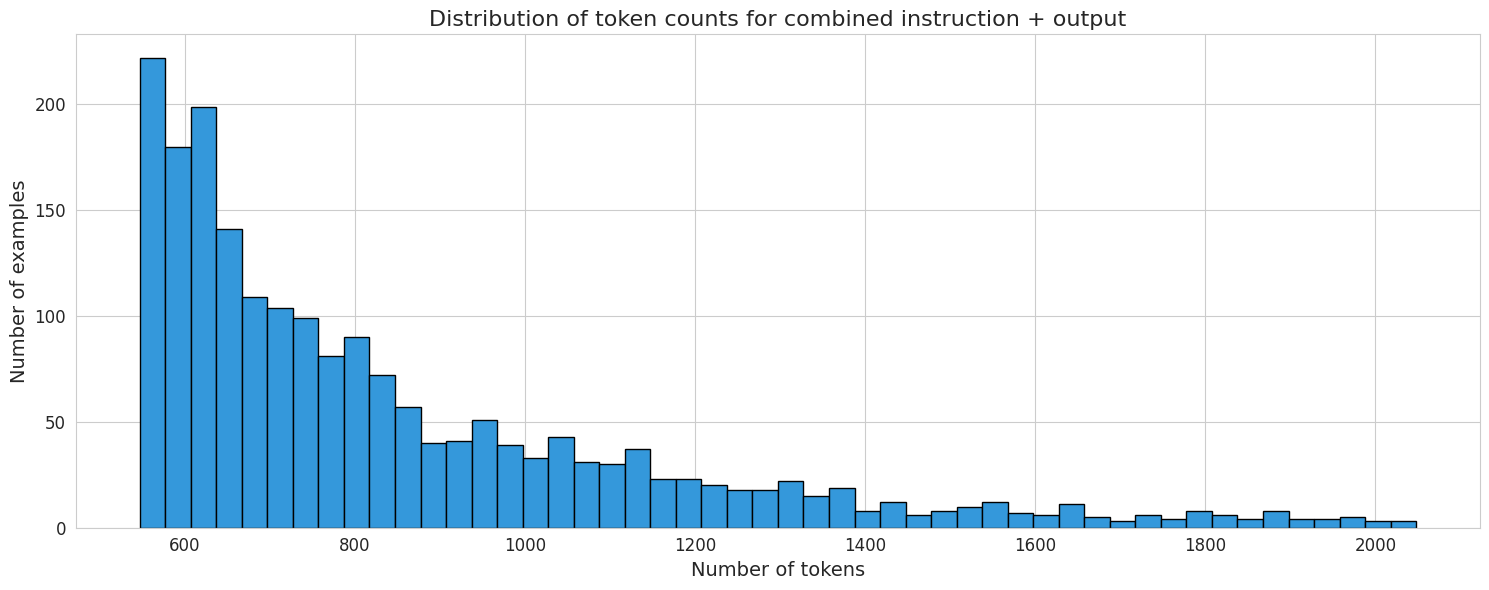

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the new distribution of token counts after top k sampling
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# to check out the samples
dataset['train'].to_pandas()

,instruction,output
0,What are the treatments for Transitional Cell ...,Key Points\n - There are di...
1,What are the treatments for Cystic Fibrosis ?,"Cystic fibrosis (CF) has no cure. However, tre..."
2,What are the stages of Colon Cancer ?,Key Points\n - After colon ...
3,What are the treatments for Gastrointestinal S...,Key Points\n - There are di...
4,What are the stages of Rectal Cancer ?,Key Points\n - After recta...
...,...,...
1995,What are the symptoms of Acromegaloid facial a...,What are the signs and symptoms of Acromegaloi...
1996,What is (are) Psoriasis ?,Psoriasis (sow RYE uh sis) is a chronic skin d...
1997,How to diagnose Disseminated Intravascular Coa...,Your doctor will diagnose disseminated intrava...
1998,What causes High Blood Cholesterol ?,Many factors can affect the cholesterol levels...


## Create Chat Templates



In [ ]:
# push the dataset to the huggingface hub
dataset.push_to_hub("miniMedicalQA", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Polyjuiceai/miniMedicalQA/commit/3955ceba5c6ffad98d5aee31259d0946dc5ffc8c', commit_message='Upload dataset', commit_description='', oid='3955ceba5c6ffad98d5aee31259d0946dc5ffc8c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction: \n{example['output']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction: \nKey Points\n ...,Key Points\n - There are di...
1,### Instruction: \nCystic fibrosis (CF) has no...,"Cystic fibrosis (CF) has no cure. However, tre..."
2,### Instruction: \nKey Points\n ...,Key Points\n - After colon ...
3,### Instruction: \nKey Points\n ...,Key Points\n - There are di...
4,### Instruction: \nKey Points\n ...,Key Points\n - After recta...
...,...,...
1995,### Instruction: \nWhat are the signs and symp...,What are the signs and symptoms of Acromegaloi...
1996,### Instruction: \nPsoriasis (sow RYE uh sis) ...,Psoriasis (sow RYE uh sis) is a chronic skin d...
1997,### Instruction: \nYour doctor will diagnose d...,Your doctor will diagnose disseminated intrava...
1998,### Instruction: \nMany factors can affect the...,Many factors can affect the cholesterol levels...


In [ ]:
# push the dataset to the huggingface hub
dataset.push_to_hub("miniMedicalQAChatTemplate", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Polyjuiceai/miniMedicalQAChatTemplate/commit/979356a057e87326d9cd087c28969df2be82e40d', commit_message='Upload dataset', commit_description='', oid='979356a057e87326d9cd087c28969df2be82e40d', pr_url=None, pr_revision=None, pr_num=None)